In [7]:
import numpy as np
import scipy.misc
import glob
import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers.merge import Concatenate
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

labels = ['gyoku', 'ou', 'kin', 'gin', 'kei', 'kyo', 'kaku', 'hi', 'fu', 'narigin', 'narikei', 'narikyo', 'uma', 'ryu', 'to']
num_classes = len(labels)

# input image dimensions
img_rows, img_cols = 48, 48
input_shape = (img_rows, img_cols, 1)

series_imgs = []
series_labels = []
for i, series in enumerate(glob.glob("learn/*.npz")):
    file = np.load(series)
    series_imgs.append(file['imgs'].astype(np.float32))
    series_labels.append(file['labels'])
num_series = len(series_imgs)

In [8]:
# conv module
conv_in = Input(shape=input_shape)
## first layer
x = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(conv_in)
x = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
## second layer
x = Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
conv_out = Flatten()(x)

conv_model = Model(conv_in, conv_out)

# main network
main_input = Input(shape=input_shape)
x = conv_model(main_input)
x = Dense(256, activation='relu')(x)
main_output = Dropout(0.5)(x)

inputs = [main_input]
outputs = [main_output]

# hint network
num_hint = 5
for i in range(num_hint):
    hint_input = Input(shape=input_shape)
    x = conv_model(hint_input)
    hint_output = Dense(1, activation='relu')(x)
    inputs.append(hint_input)
    outputs.append(hint_output)

concatenated_neuron = Concatenate()(outputs)
out = Dense(num_classes, activation='softmax')(concatenated_neuron)
model = Model(inputs, out)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 48, 48, 1)     0                                            
____________________________________________________________________________________________________
input_10 (InputLayer)            (None, 48, 48, 1)     0                                            
____________________________________________________________________________________________________
input_11 (InputLayer)            (None, 48, 48, 1)     0                                            
____________________________________________________________________________________________________
input_12 (InputLayer)            (None, 48, 48, 1)     0                                            
___________________________________________________________________________________________

In [9]:
# load all
x_all = np.empty((0, img_rows, img_cols))
y_all = np.empty((0, 2), np.int32)
for i in range(num_series):
    num_imgs = len(series_imgs[i])
    x_all = np.r_[x_all, series_imgs[i]]
    label_indices = []
    for j, label in enumerate(series_labels[i]):
        label_indices.append(labels.index(label))
    label_and_series = np.c_[label_indices, np.full((num_imgs), i)]
    y_all = np.r_[y_all, label_and_series]

# reshape to TF
x_all = x_all.reshape(x_all.shape[0], img_rows, img_cols, 1)
x_all = x_all.astype(np.float32)
x_all /= 255

# series list
x_all_series = []
for i in range(num_series):
    x_all_series.append(x_all[np.where(y_all[:, 1] == i)])

train_ids = np.where(y_all[:, 1] != 8)
test_ids = np.where(y_all[:, 1] == 8)
x_train = x_all[train_ids]
x_test = x_all[test_ids]
y_series_train = y_all[train_ids]
y_series_test = y_all[test_ids]
print(test_ids)
# x_train, x_test, y_series_train, y_series_test = train_test_split(x_all, y_all, test_size=0.1)

gen_series = []
for i in range(num_series):
    g = ImageDataGenerator(rotation_range=15, zoom_range=0.25)
    gen_series.append(g.flow(x_all_series[i], np.zeros((x_all_series[i].shape[0], 1)), batch_size=num_hint))
def generate_hint(series):
    hint_imgs, dummy = gen_series[series].next()
    if hint_imgs.shape[0] < num_hint:
        zero = np.zeros((num_hint - hint_imgs.shape[0], img_rows, img_cols, 1), np.float32)
        hint_imgs = np.r_[hint_imgs, zero]
        np.random.shuffle(hint_imgs)
    return hint_imgs

def data_generator_with_hint(x_batch, y_batch, x_all_series, batch_size=16):
    datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.25)
    for x, y in datagen.flow(x_batch, y_batch, batch_size=batch_size):
        labels = keras.utils.to_categorical(y[:, 0], num_classes)
        series_ids = y[:, 1]
        x_with_hint = []
        for i, series_id in enumerate(series_ids):
            hint_imgs = generate_hint(series_id)
            x_with_hint.append(np.r_[[x[i]], hint_imgs])
        yield_list = list(np.array(x_with_hint).swapaxes(1, 0))
        yield (yield_list, labels)

(array([ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110]),)


In [10]:
x_test_with_hint = []
for i, series_id in enumerate(y_series_test[:, 1]):
    hint_imgs = generate_hint(series_id)
    x_test_with_hint.append(np.r_[[x_test[i]], hint_imgs])
x_test_with_hint = list(np.array(x_test_with_hint).swapaxes(1, 0))
y_test = keras.utils.to_categorical(y_series_test[:, 0], num_classes)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.fit_generator(data_generator_with_hint(x_train, y_series_train, x_all_series, batch_size=16), steps_per_epoch=x_train.shape[0],
#                     epochs=20, verbose=1)
                    epochs=20, verbose=1, validation_data=(x_test_with_hint, y_test))
# score = model.evaluate(x_test_list, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

Epoch 1/20
326/326 [==============================] - 19s - loss: 2.5238 - acc: 0.1334 - val_loss: 1.9503 - val_acc: 0.3333
Epoch 2/20
326/326 [==============================] - 18s - loss: 1.5872 - acc: 0.4434 - val_loss: 1.1503 - val_acc: 0.6667
Epoch 3/20
326/326 [==============================] - 18s - loss: 1.0891 - acc: 0.6090 - val_loss: 0.8036 - val_acc: 0.8667
Epoch 4/20
326/326 [==============================] - 18s - loss: 0.8013 - acc: 0.7127 - val_loss: 0.5480 - val_acc: 0.8667
Epoch 5/20
326/326 [==============================] - 18s - loss: 0.6097 - acc: 0.7789 - val_loss: 0.4157 - val_acc: 0.8667
Epoch 6/20
326/326 [==============================] - 18s - loss: 0.5371 - acc: 0.8085 - val_loss: 0.4103 - val_acc: 0.8667
Epoch 7/20
326/326 [==============================] - 18s - loss: 0.4160 - acc: 0.8475 - val_loss: 0.3275 - val_acc: 0.9333
Epoch 8/20
326/326 [==============================] - 18s - loss: 0.3391 - acc: 0.8788 - val_loss: 0.4708 - val_acc: 0.8667
Epoch 9/

In [11]:
pred_res = model.predict(x_test_with_hint)
res = np.array([np.argmax(r) for r in pred_res])
ans = np.array([np.where(y == 1)[0][0] for y in y_test])
print(res)
print(ans)
errors = np.where(res != ans)[0]
print(errors)

[ 0  1  2  3  4  5  6  7  8  9 10 14 12 13 14]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[11]


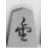

to


In [12]:
from io import BytesIO
from IPython import display
from PIL import Image

def display_image(arr):
    b = BytesIO()
    Image.fromarray(np.uint8(arr)).save(b, format='png')
    data = b.getvalue()
    display.display(display.Image(data=data, format='png', embed=True))

for e in errors:
    display_image(np.uint8(x_test_with_hint[0][e] * 255)[:, :, 0])
    if len(labels) > res[e]:
        print(labels[res[e]])
    else:
        print("p")
        print(labels[res[e] - len(labels)])